In [37]:
# Core
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import time
import warnings
import os

from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# Ignore warnings
warnings.filterwarnings("ignore")

In [38]:
# Customize matplotlib
mpl.rc("axes", labelsize=12, titlesize=14)
mpl.rc("figure", figsize=(8, 4))

# Customize seaborn
sns.set_style("darkgrid")
sns.set_palette("muted")

In [39]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ccdata/CC GENERAL.csv


This case requires to develop a customer segmentation to define marketing strategy. The dataset summarizes the usage behavior of about 9000 active credit card holders during the last 6 months. The file is at a customer level with 18 behavioral variables.

Features:
- __CUST_ID:__ Identification of Credit Cardholder (Categorical)
- __BALANCE:__ Balance amount left in their account to make purchases
- __BALANCE_FREQUENCY:__ How frequently the Balance is updated, score between 0 and 1 (1 = frequently updated, 0 = not frequently updated)
- __PURCHASES:__ Amount of purchases made from the account
- __ONEOFF_PURCHASES:__ Maximum purchase amount did in one-go
- __INSTALLMENTS_PURCHASES:__ Amount of purchase done in installment
- __CASH_ADVANCE:__ Cash in advance given by the user
- __PURCHASES_FREQUENCY:__ How frequently the Purchases are being made score between 0 and 1 (1 = frequently purchased, 0 = not frequently purchased)
- __ONEOFF_PURCHASES_FREQUENCY:__ How frequently Purchases are happening in one go (1 = frequently purchased, 0 = not frequently purchased)
- __PURCHASES_INSTALLMENTS_FREQUENCY:__ How frequently purchases in installments are being done (1 = frequently done, 0 = not frequently done)
- __CASH_ADVANCE_FREQUENCY:__ How frequently is the cash in advance being paid
- __CASH_ADVANCE_TRX:__ Number of Transactions made with "Cash in Advanced"
- __PURCHASES_TRX:__ Number of purchase transactions made
- __CREDIT_LIMIT:__ Limit of Credit Card for user
- __PAYMENTS:__ Amount of Payment done by the user
- __MINIMUM_PAYMENTS:__ Minimum amount of payments made by the user
- __PRC_FULL_PAYMENT:__ Percent of full payment paid by the user
- __TENURE:__ Tenure of credit card service for user

In [40]:
df = pd.read_csv("/kaggle/input/ccdata/CC GENERAL.csv")
print("Dataset shape: ", df.shape)
print("")
df.head()

Dataset shape:  (8950, 18)



,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


# <b><span style="color: #9d4edd">1 EDA</span></b>

In [41]:
def summary(df):    
    summ = pd.DataFrame(df.dtypes, columns=["dtypes"])
    summ["count"] = df.count().values
    summ["#missing"] = df.isna().sum().values
    summ["%missing"] = np.round(df.isna().sum().values / len(df), 3)
    summ["unique"] = df.nunique().values
    summ["mean"] = np.zeros(df.shape[1])
    summ["std"] = np.zeros(df.shape[1])
    summ["mean"][1:] = df.mean().values
    summ["std"][1:] = df.std().values
    summ["min"] = df.min().values 
    summ["max"] = df.max().values 
    print(f"The dataset has {df.duplicated().sum()} duplicate values\n")
    
    return summ

In [42]:
summary(df)

The dataset has 0 duplicate values



,dtypes,count,#missing,%missing,unique,mean,std,min,max
CUST_ID,object,8950,0,0.000,8950,0.000000,0.000000,C10001,C19190
BALANCE,float64,8950,0,0.000,8871,1564.474828,2081.531879,0.0,19043.13856
BALANCE_FREQUENCY,float64,8950,0,0.000,43,0.877271,0.236904,0.0,1.0
PURCHASES,float64,8950,0,0.000,6203,1003.204834,2136.634782,0.0,49039.57
ONEOFF_PURCHASES,float64,8950,0,0.000,4014,592.437371,1659.887917,0.0,40761.25
INSTALLMENTS_PURCHASES,float64,8950,0,0.000,4452,411.067645,904.338115,0.0,22500.0
CASH_ADVANCE,float64,8950,0,0.000,4323,978.871112,2097.163877,0.0,47137.21176
PURCHASES_FREQUENCY,float64,8950,0,0.000,47,0.490351,0.401371,0.0,1.0
ONEOFF_PURCHASES_FREQUENCY,float64,8950,0,0.000,47,0.202458,0.298336,0.0,1.0
PURCHASES_INSTALLMENTS_FREQUENCY,float64,8950,0,0.000,47,0.364437,0.397448,0.0,1.0


Notes:
- The data types are ok
- MINIMUM_PAYMENTS has a lot of missing values. We can take care of them later
- Some columns have a big difference between min and max, so they are probably skewed

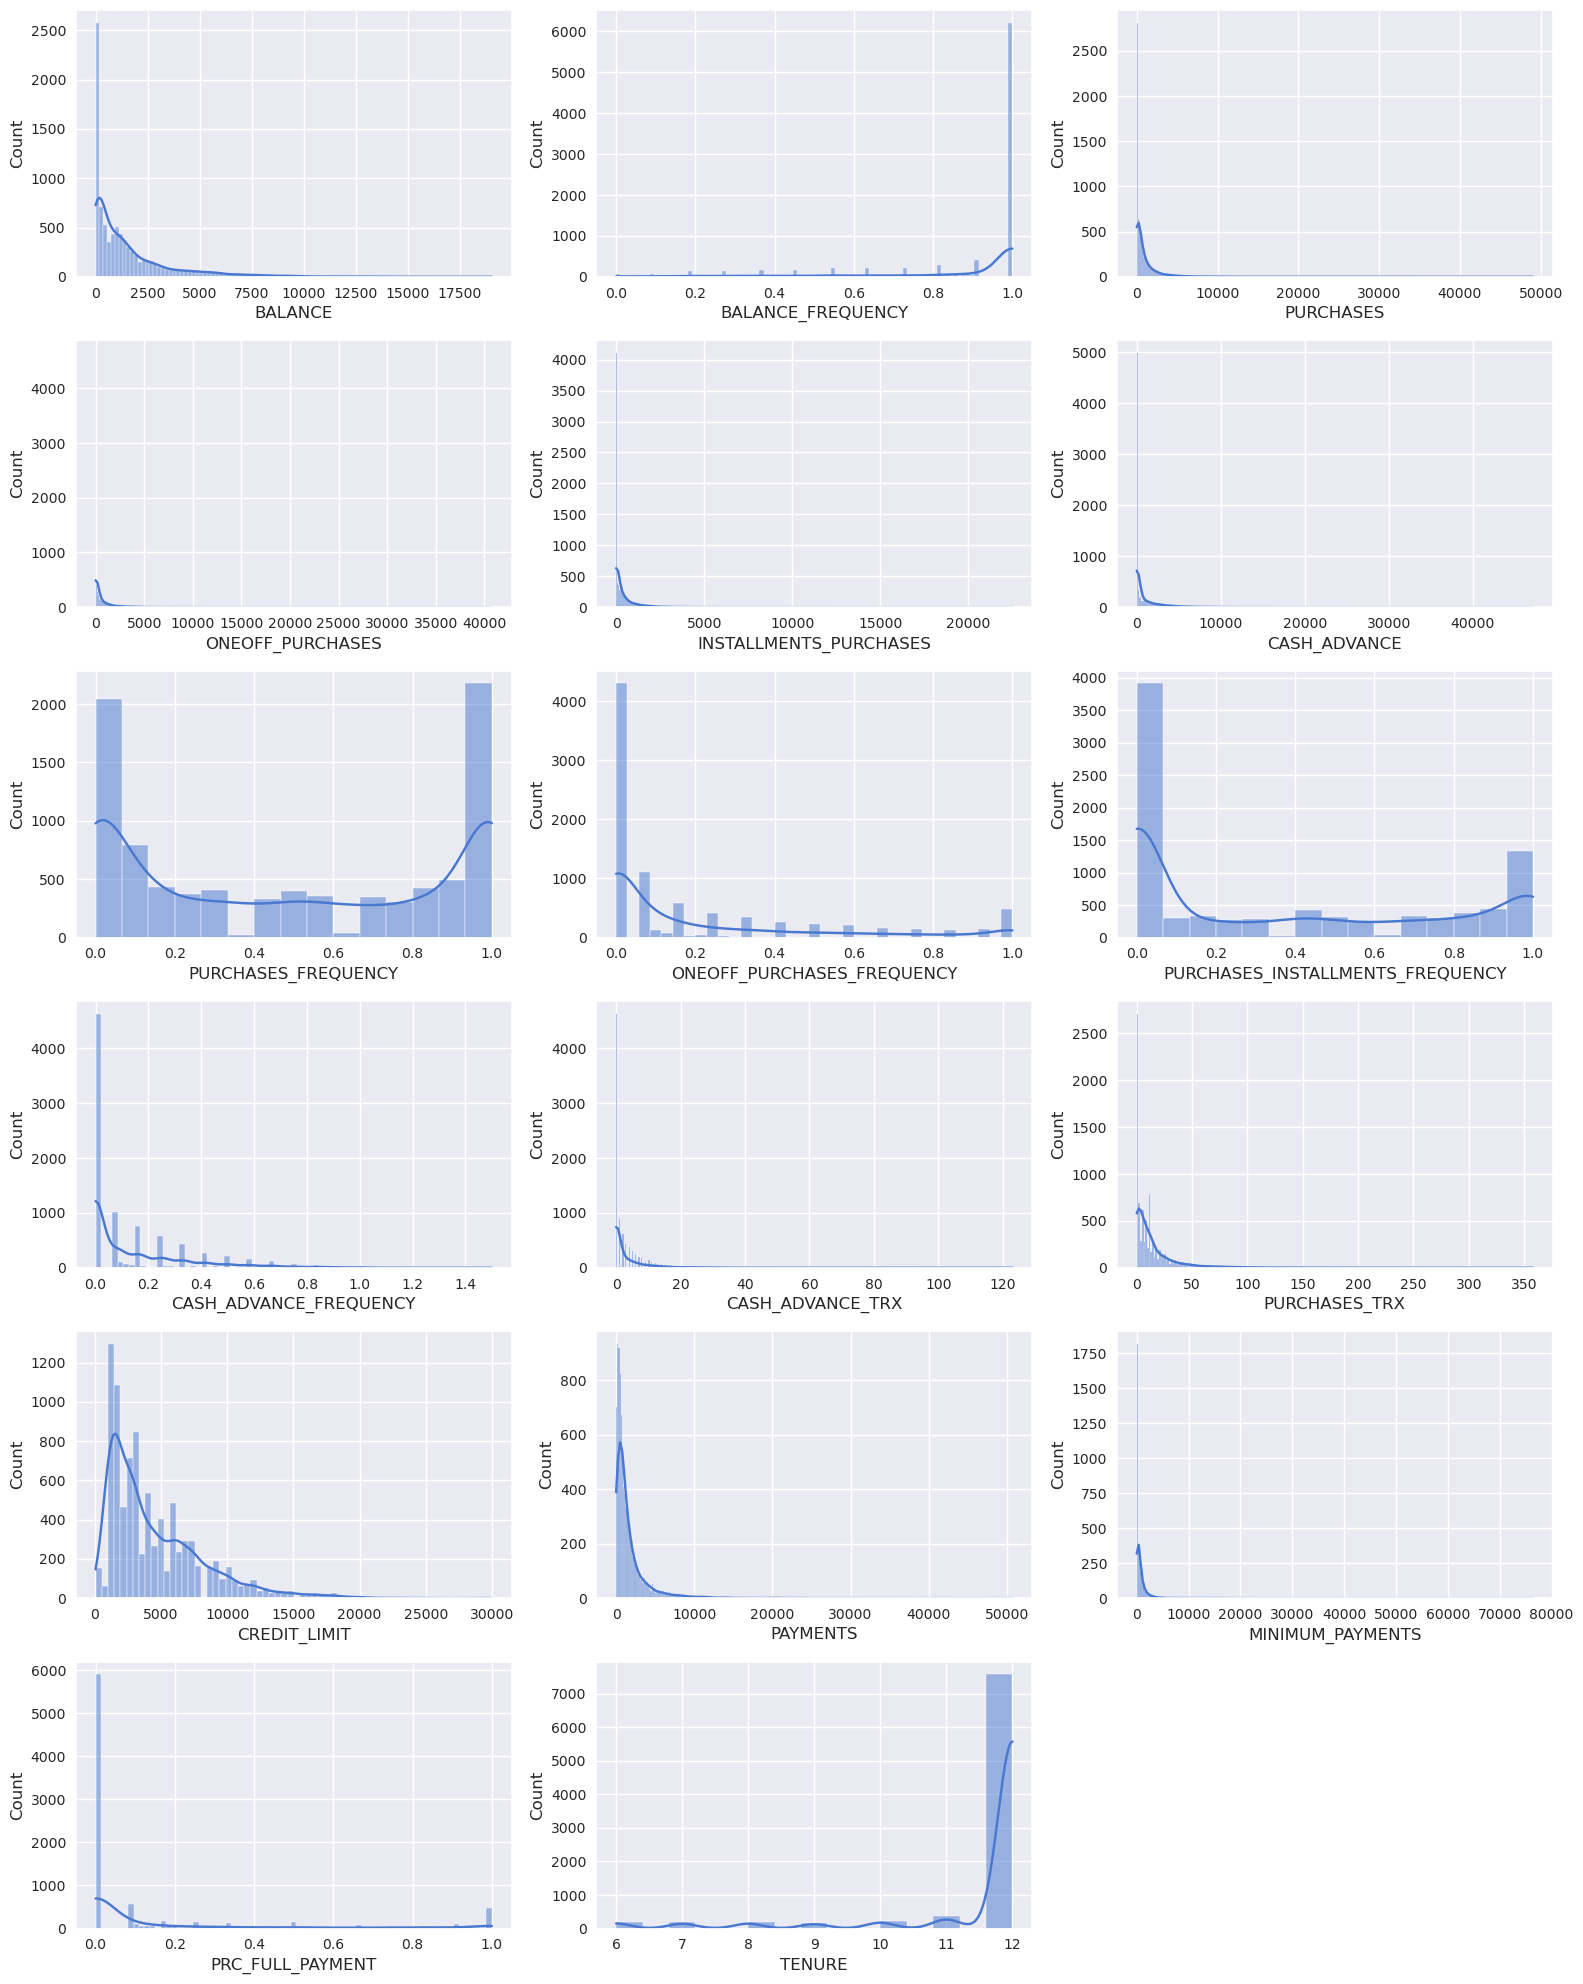

In [43]:
num_cols = df.select_dtypes(exclude="object").columns.tolist()

fig = plt.figure(figsize=(16, 20))
for i, col in enumerate(num_cols):
    plt.subplot(6, 3, i+1)
    sns.histplot(data=df, x=col, kde=True)
    
fig.tight_layout()    
plt.show()

Notes:
- As said previously, almost all features are right skewed
- Most people don't make purchases at all
- Most people have a low amount of money in their accounts and a low credit limit
- 12-months tenure is preferable for most users

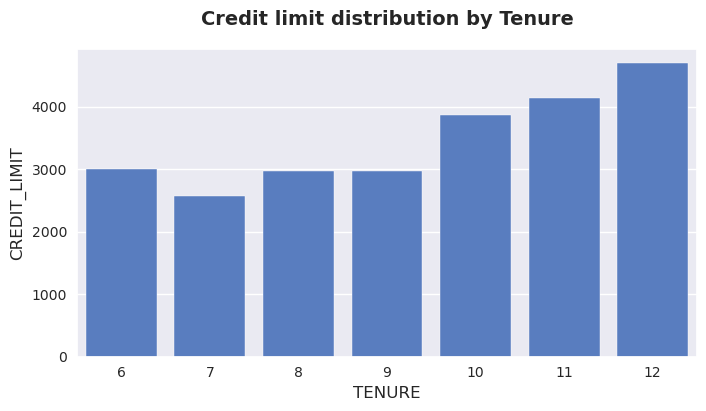

In [44]:
title = dict(fontweight="heavy", fontfamily="arial", y=1.05)

fig, ax = plt.subplots()
sns.barplot(data=df, x="TENURE", y="CREDIT_LIMIT", errorbar=None, color="C0", ax=ax)
ax.set_title("Credit limit distribution by Tenure", **title)

plt.show()

People with higher average credit limit have a higher tenure.

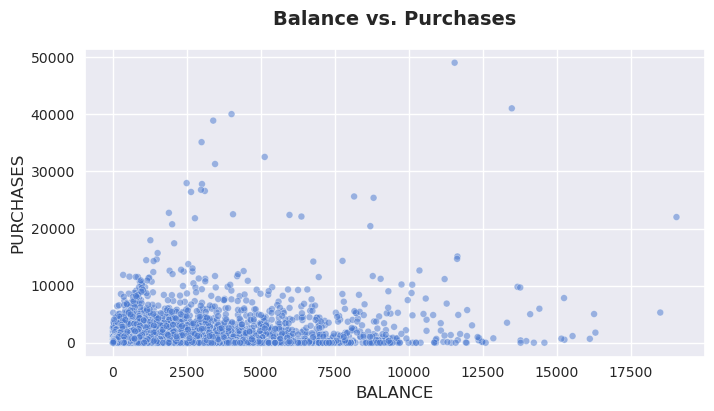

In [45]:
sns.scatterplot(data=df, x="BALANCE", y="PURCHASES", size=0.5, legend=None, alpha=0.5)
plt.title("Balance vs. Purchases", **title)

plt.show()

__BALANCE__ and __PURCHASES__ have a weak correlation, so even if a user has a lot of money, they won't make an expensive purchase.

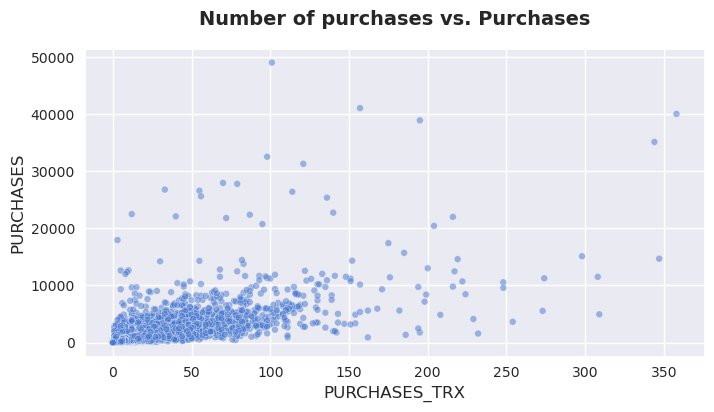

In [46]:
sns.scatterplot(data=df, x="PURCHASES_TRX", y="PURCHASES", size=0.5, legend=None, alpha=0.5)
plt.title("Number of purchases vs. Purchases", **title)

plt.show()

This plot shows us that these two features are strongly correlated, as expected. People who buy more, spend more.

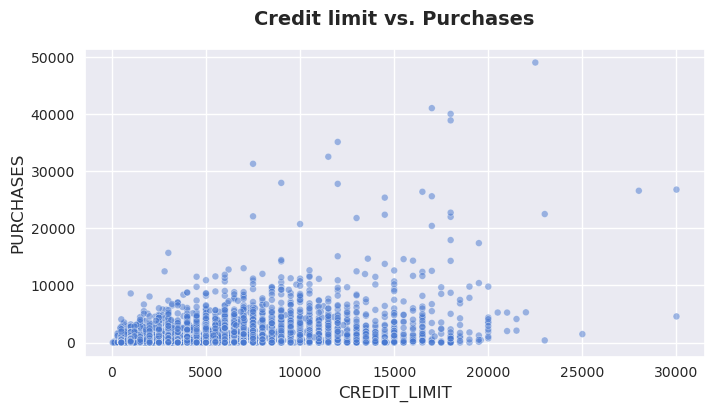

In [47]:
sns.scatterplot(data=df, x="CREDIT_LIMIT", y="PURCHASES", size=0.5, legend=None, alpha=0.5)
plt.title("Credit limit vs. Purchases", **title)

plt.show()

__CREDIT_LIMIT__ and __PURCHASES__ have a moderate correlation, so people with higher credit limits have a tendency to make more purchases.

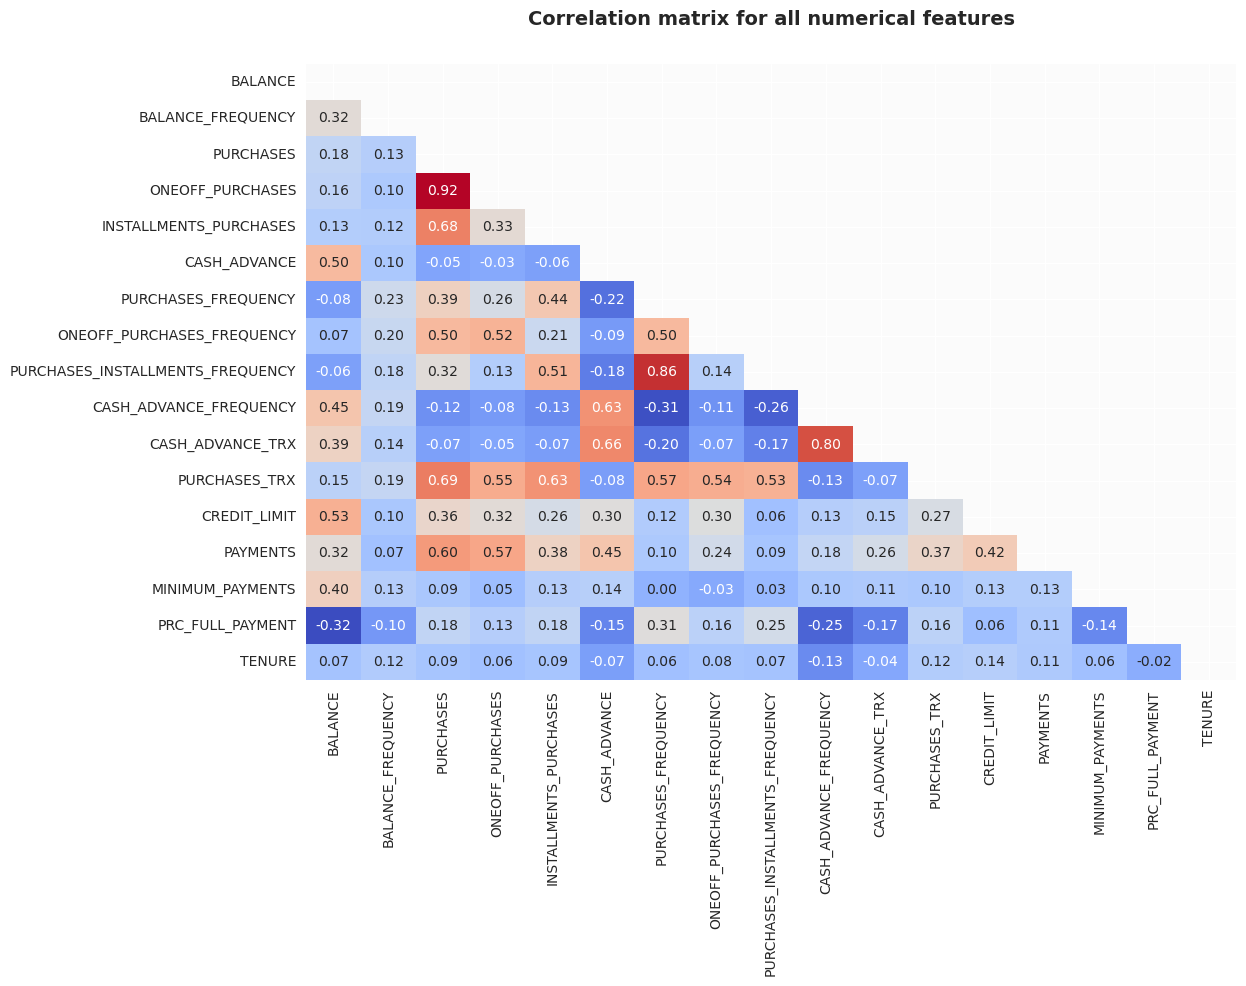

In [48]:
mask = np.triu(np.ones_like(df.corr(), dtype=bool))

plt.figure(figsize=(12,8))
ax = sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm", cbar=False, mask=mask, annot_kws={"size":10})
ax.set_title("Correlation matrix for all numerical features", **title)
ax.set_facecolor("#FBFBFB")

plt.show()

Some features have moderate to high correlation values to other features (>0.5 to 1). But most of them are not quite correlated.


# <b><span style="color: #9d4edd">2 Preprocessing</span></b>

## <b><span style="color: #9d4edd">2.1 Dropping features</span></b>

In [49]:
df = df.drop("CUST_ID", axis=1)
df.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


## <b><span style="color: #9d4edd">2.2 Imputing missing values</span></b>

Since the dataset is about clustering, imputation will use <code>KNNImputer()</code> to avoid biased clustering results. The mean value from the nearest <code>n_neighbors</code> found in the dataset is used to impute the missing values for each sample.

In [50]:
mean_before = df[["MINIMUM_PAYMENTS", "CREDIT_LIMIT"]].mean()

# Columns with null values
null_cols = df.columns[df.isna().any()].tolist()

# Imputation with KNNImputer
imputer = KNNImputer()
df_imp = pd.DataFrame(imputer.fit_transform(df[null_cols]), columns=null_cols)
df = df.fillna(df_imp)

mean_after = df[["MINIMUM_PAYMENTS", "CREDIT_LIMIT"]].mean()
print("Mean before:\n", mean_before)
print("")
print("Mean after:\n", mean_after)
print("")
df.isna().sum()

Mean before:
 MINIMUM_PAYMENTS     864.206542
CREDIT_LIMIT        4494.449450
dtype: float64

Mean after:
 MINIMUM_PAYMENTS     868.716633
CREDIT_LIMIT        4494.293646
dtype: float64



BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64

The imputation worked really well. The mean after is pretty close to the original.

## <b><span style="color: #9d4edd">2.3 Scaling</span></b>

In [51]:
# Using StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(df)
print("X shape:", X.shape)

X shape: (8950, 17)


## <b><span style="color: #9d4edd">2.4 PCA</span></b>

We will use PCA to reduce the dimension of our data to 2. That way we can remove data noise, decrease computation cost and visualize the clusters.

In [52]:
seed = 42
pca = PCA(n_components=2, random_state=seed)
X_pca = pca.fit_transform(X)
print("X shape:", X_pca.shape)

X shape: (8950, 2)


# <b><span style="color: #9d4edd">3 Clustering</span></b>

## <b><span style="color: #9d4edd">3.1 K-Means</span></b>

In [53]:
# KMeans
k_range = range(2, 10)
kmeans_per_k = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=seed).fit(X_pca)
    kmeans_per_k.append(kmeans) 

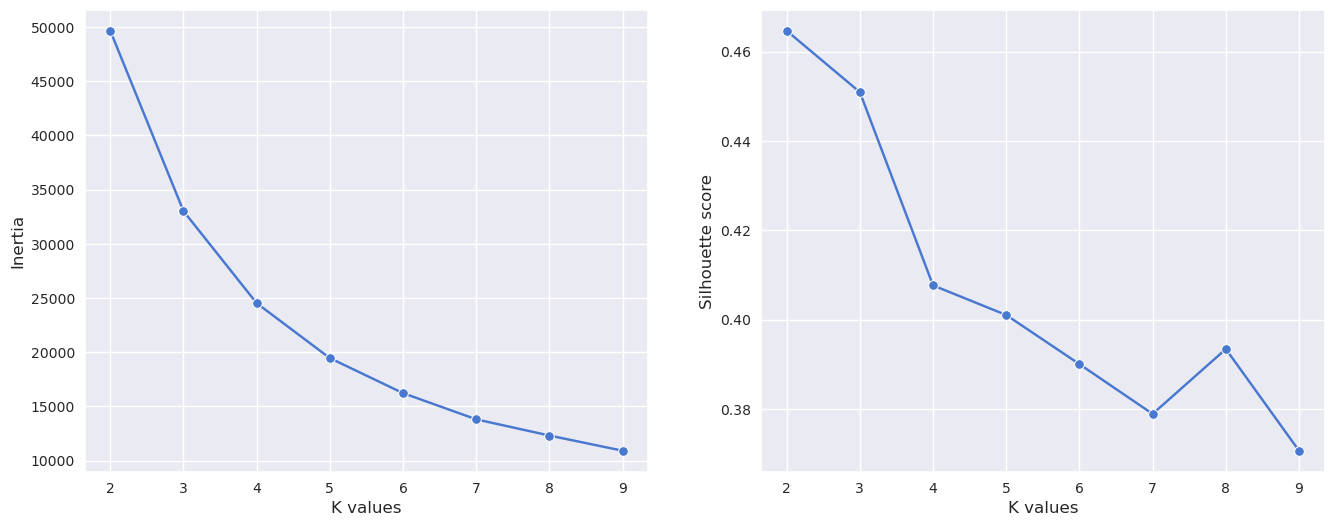

In [54]:
def plot_optimal_k(kmeans_per_k: list):
    
    # Inertia
    inertias = [model.inertia_ for model in kmeans_per_k]
    
    # Silhouette score
    silhouette_scores = [silhouette_score(X_pca, model.labels_) for model in kmeans_per_k]

    fig, ax = plt.subplots(figsize=(16, 6))
    # Plot elbow score
    plt.subplot(1, 2, 1)
    sns.lineplot(x=k_range, y=inertias, marker="o")
    plt.ylabel("Inertia")
    plt.xlabel("K values")

    # Plot silhouette score
    plt.subplot(1, 2, 2)
    sns.lineplot(x=k_range, y=silhouette_scores, marker="o")
    plt.ylabel("Silhouette score")
    plt.xlabel("K values")
    
    plt.show()

# Calling the function
plot_optimal_k(kmeans_per_k)

We can see the elbow in <b>k = 4</b>. The silhouette score in <b>k = 4</b> is better than the rest too (excluding 2 and 3 of course).

We can now apply the algorithm using the optimal k value.

In [55]:
best_model = kmeans_per_k[2]
y_kmeans = best_model.predict(X_pca)

In [56]:
# def plot_decision_boundaries(clusterer, X, ax, colors, resolution=1000):
#     mins = X.min(axis=0) - 0.1
#     maxs = X.max(axis=0) + 0.1
#     xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
#                          np.linspace(mins[1], maxs[1], resolution))
#     Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
#     Z = Z.reshape(xx.shape)

#     ax.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
#                 colors=colors, alpha=0.8)
#     ax.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
#                 linewidths=1, colors='k')

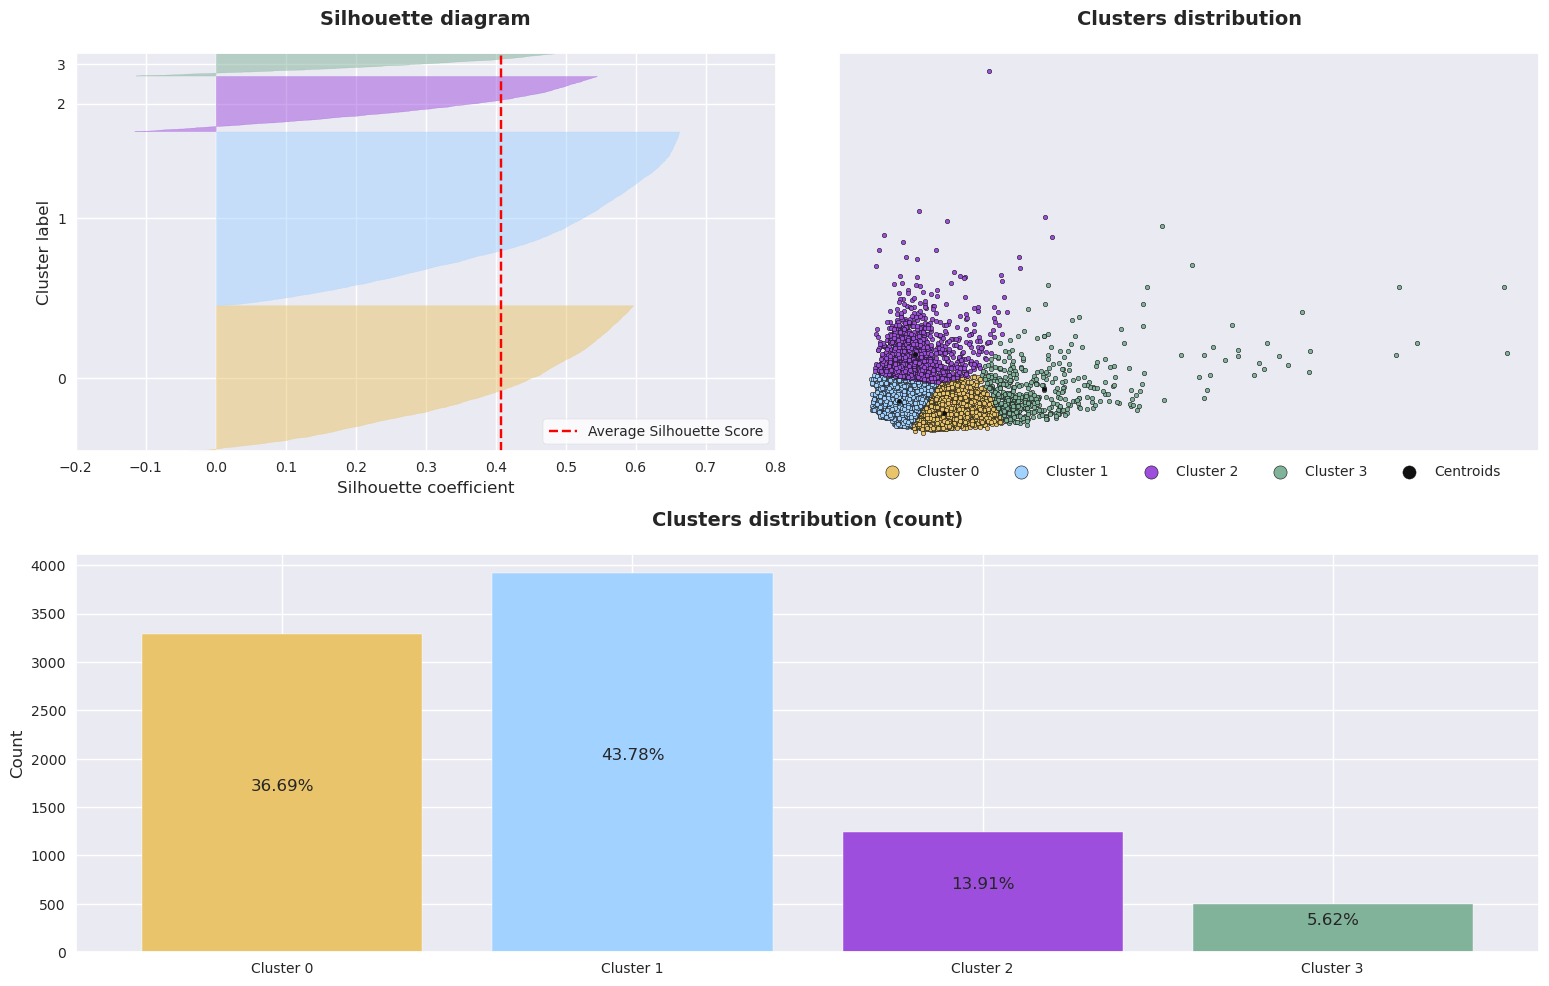

In [57]:
def plot_kmeans_clusters(clusterer, y_kmeans):
    cluster_colors = ["#e9c46a", "#a2d2ff", "#9d4edd", "#81b29a"]
    labels = ["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3", "Centroids"]

    # Percentage labels
    unique, counts = np.unique(y_kmeans, return_counts=True)
    count_dict = dict(zip(labels, counts))
    total = sum(count_dict.values())
    label_dict = {key: round(value/total*100, 2) for key, value in count_dict.items()}
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10), layout="constrained")

    # Silhouette plot
    s_viz = SilhouetteVisualizer(clusterer, colors=cluster_colors, ax=ax1)
    s_viz.fit(X_pca)
    s_viz.finalize()
    s_viz.ax.set_title("Silhouette diagram", **title)
    s_viz.ax.set(xlabel="Silhouette coefficient", ylabel="Cluster label")
    s_viz.ax.legend(loc="lower right", frameon=True, fancybox=True, facecolor="w")

    # Scatter plot
    for i in unique:
        ax2.scatter(X_pca[y_kmeans==i, 0], X_pca[y_kmeans==i, 1], c=cluster_colors[i], linewidth=0.4, edgecolor="k", s=10)
    ax2.scatter(clusterer.cluster_centers_[:, 0], clusterer.cluster_centers_[:, 1], c="k", s=10)
    ax2.set_title("Clusters distribution", **title)
    ax2.set(xticks=[], yticks=[])
    ax2.legend(labels, ncols=len(labels), loc="lower center", bbox_to_anchor=(0.5, -0.1), markerscale=3)
    
    # Bar plot
    ax3 = plt.subplot(2, 2, (3, 4))
    bars = ax3.bar(x=unique, height=counts, color=cluster_colors)
    ax3.set_title("Clusters distribution (count)", **title)
    ax3.set_ylabel("Count")
    ax3.set_xticks(ticks=unique, labels=labels[:-1])
    for bar in bars:
        ax3.annotate("{:.2%}".format(bar.get_height() / total), xy=(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2), 
                xytext=(0, 0), textcoords="offset points", ha="center", va="bottom")

    fig.tight_layout()
    plt.show()
    
# Calling the function
plot_kmeans_clusters(best_model, y_kmeans)

The plots above illustrates the silhouette coefficient values for each cluster, the distribution in the scatter plot, and the number of customers in each cluster, respectivily. From the silhouette plot, the silhouette value of each cluster is above average, indicating all clusters are "good". In addition, all the clusters have a similar wide of fluctuations, however, clusters 0 and 1 have way more instances than the others (confirmed by the count plot).

Next, we need to evaluate the clusters. Silhouette score, Davies-Bouldin index, and Calinski-Harabasz index are good evaluation metrics for clustering.
- __Silhouette score:__ measures the between-cluster distance against within-cluster distance. A higher score signifies better-defined clusters.
- __Davies-Bouldin index:__ measures the size of clusters against the average distance between clusters. A lower score signifies better-defined clusters.
- __Calinski-Harabasz index:__ measures the between-cluster dispersion against within-cluster dispersion. A higher score signifies better-defined clusters.

In [58]:
def clustering_evaluation(X, y_kmeans):
    s_score = np.round(silhouette_score(X, y_kmeans), 3)
    db_score = np.round(davies_bouldin_score(X, y_kmeans), 3)
    ch_score = np.round(calinski_harabasz_score(X, y_kmeans), 3)
    print("Clustering Evaluation")
    print("-"*25)
    print("Silhoutte score:", s_score)
    print("Davies-Bouldin index:", db_score)
    print("Calinski-Harabasz index:", ch_score)
    
clustering_evaluation(X_pca, y_kmeans)

Clustering Evaluation
-------------------------
Silhoutte score: 0.408
Davies-Bouldin index: 0.801
Calinski-Harabasz index: 5823.678


Based on the results above, we can conclude that the model with 4 clusters is decent. As shown in the scatter plot, there is no good separation between clusters, so they are overlapping and it will lead to just "ok" scores.

## <b><span style="color: #9d4edd">3.2 DBSCAN</span></b>

First of all, we need to find the optimal epsilon for the DBSCAN algorithm. We can calculate the distance from each point to its closest neighbour using the <code>NearestNeighbors</code>. The point itself is included in <code>n_neighbors</code>. The kneighbors method returns two arrays, one which contains the distance to the closest <code>n_neighbors</code> points and the other which contains the index for each of those points.

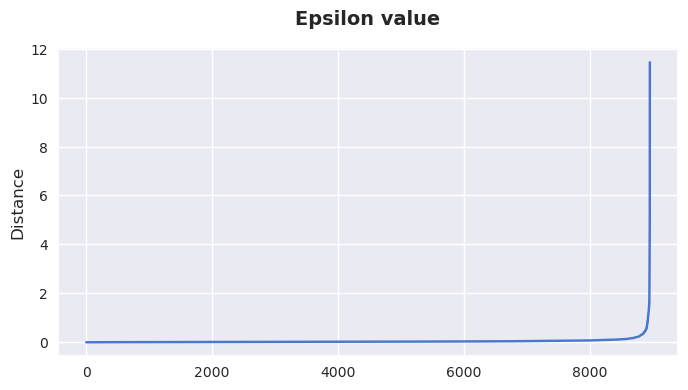

In [59]:
def plot_epsilon(X):
    # Find nearest neighbors
    neigh = NearestNeighbors(n_neighbors=2)
    nbrs = neigh.fit(X)
    distances, indices = nbrs.kneighbors(X)
    
    # Plot epsilon
    distances = np.sort(distances, axis=0)
    distances_1 = distances[:, 1]
    plt.plot(distances_1)
    plt.title("Epsilon value", **title)
    plt.ylabel("Distance")
    
    plt.show()

# Calling the function
plot_epsilon(X_pca)

The maximum curvature is close to 2, thus we'll choose 2 to be our epsilon. The parameter <code>min_samples</code> will be the default 5.

In [60]:
dbscan = DBSCAN(eps=2, min_samples=5)
y_dbscan = dbscan.fit_predict(X_pca)

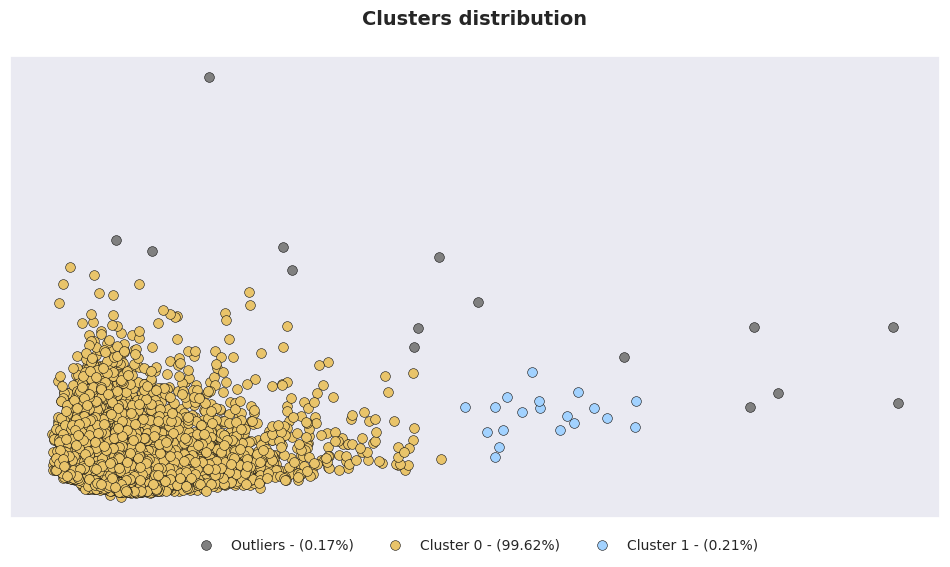

In [61]:
def plot_dbscan_clusters(y_dbscan):
    cluster_colors = ["#e9c46a", "#a2d2ff", "#9d4edd", "#81b29a"]
    labels = ["Outliers", "Cluster 0", "Cluster 1"]
    
    # Percentage labels
    unique, counts = np.unique(y_dbscan, return_counts=True)
    count_dict = dict(zip(labels, counts))
    total = sum(count_dict.values())
    label_dict = {key: round(value/total*100, 2) for key, value in count_dict.items()}
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Scatter plot
    for i in unique:
        if i != -1:
            ax.scatter(X_pca[y_dbscan==i, 0], X_pca[y_dbscan==i, 1], c=cluster_colors[i], linewidth=0.4, edgecolor="k")
        else:
            ax.scatter(X_pca[y_dbscan==-1, 0], X_pca[y_dbscan==-1, 1], c="grey", linewidth=0.4, edgecolor="k")
        ax.set_title("Clusters distribution", **title)
        ax.set(xticks=[], yticks=[])
        ax.legend([f"{key} - ({value}%)" for key, value in label_dict.items()], ncols=len(labels), loc="lower center", bbox_to_anchor=(0.5, -0.1))
        

# Calling the function
plot_dbscan_clusters(y_dbscan)

DBSCAN gives us 2 clusters. Cluster 0 has almost all data points, because they are really close to each other. The model also detected some outliers, since some points are too far from the rest.

We can now evaluate the model.

In [62]:
clustering_evaluation(X_pca, y_dbscan)

Clustering Evaluation
-------------------------
Silhoutte score: 0.803
Davies-Bouldin index: 1.269
Calinski-Harabasz index: 698.168


The results show that DBSCAN with two clusters and outliers scored fairly. The silhouette score is higher than K-Means because the clusters are better defined with DBSCAN. The Davies-Bouldin index, though, is higher than K-Means, which indicates a worse performance. Also, the Calinski-Harabasz index obtained is much lower than K-Means.

Overall, K-Means had a better performance with this dataset. So we can use this model to do _profiling_, in other words, to identify the characteristic of each cluster.

# <b><span style="color: #9d4edd">4 Profiling</span></b>

In [63]:
# Copy the original Data Frame
original_df = df.copy()

In [64]:
# Add K-Means labels to DataFrame
df["CLUSTER"] = y_kmeans

# Pivot table with all columns and their average
table = pd.pivot_table(data=df, values=num_cols, columns="CLUSTER", aggfunc=np.mean)
table["Overall mean"] = (original_df.describe().loc["mean"]).sort_index().values
table.style.background_gradient(cmap="BuGn", axis=1)

CLUSTER,0,1,2,3,Overall mean
BALANCE,824.180354,1012.915503,4510.612798,3401.840056,1564.474828
BALANCE_FREQUENCY,0.919997,0.799792,0.963486,0.988427,0.877271
CASH_ADVANCE,147.442197,614.588758,4401.478579,773.154467,978.871112
CASH_ADVANCE_FREQUENCY,0.030698,0.122459,0.470904,0.084806,0.135144
CASH_ADVANCE_TRX,0.569732,2.264421,13.771084,2.363817,3.248827
CREDIT_LIMIT,4250.051843,3109.010550,7458.798832,9541.650099,4494.293646
INSTALLMENTS_PURCHASES,614.965725,65.833785,162.619301,2383.916859,411.067645
MINIMUM_PAYMENTS,600.410547,589.839851,2065.568910,1830.297811,868.716633
ONEOFF_PURCHASES,621.738764,157.576608,300.127390,4511.889901,592.437371
ONEOFF_PURCHASES_FREQUENCY,0.301883,0.074901,0.129829,0.726667,0.202458


Cluster's characteristics:
- <b><span style="background-color: #e9c46a">Cluster 0 (Installment users):</span></b> Customers in this cluster are likely to use their credit card to make installment purchases. This is probably because they have the lowest balance and a credit limit below the average.
- <b><span style="background-color: #a2d2ff">Cluster 1 (New users/Students):</span></b> Customers in this cluster rarely use their credit card to make transactions. They have the lowest credit limit and a low balance. Also, it's possible to see that they are likely to use their credit card for cash advances.
- <b><span style="background-color: #9d4edd">Cluster 2 (Cash advance users):</span></b>  Customers in this cluster are likely to withdraw cash since they have the highest average for those features. They have the highest balance and high credit limit as well. In addition, they make high payments.
- <b><span style="background-color: #81b29a">Cluster 3 (Active users):</span></b> Customers in this cluster are active users of the credit card. This can be explained by the high average value for almost all features. Users in this cluster frequently update the balance and the balance amount is quite high. In addition, they actively make purchases and payments and have the highest credit limit.

## <b><span style="color: #9d4edd">4.1 Visualizations</span></b>

In [65]:
import re

def remove_under(feature):
    # Replace underscore with a space and return the capitalized feature
    feature = re.sub(r"_", " ", feature)
    return feature.capitalize()

In [66]:
def plot_profiling(col1: str, col2: str):
    cluster_colors = ["#e9c46a", "#a2d2ff", "#9d4edd", "#81b29a"]

    # Define figure and gridspec
    fig = plt.figure(figsize=(12, 6), layout="constrained")
    spec = fig.add_gridspec(4, 5)
    ax = fig.add_subplot(spec[:, :4])

    # Slice Data Frame
    df_slice = df[[col1, col2, "CLUSTER"]]
    clusters = sorted(df_slice["CLUSTER"].unique())
    
    # Main scatter plot
    sns.scatterplot(data=df, x=col1, y=col2, hue="CLUSTER", palette=cluster_colors, ax=ax, legend=False, linewidth=0.2, edgecolor="k")
    ax.set_title(f"{remove_under(col1)} vs {remove_under(col2)} by Cluster", **title)
    
    sub_axes = [None] * 4
    # Plot sub axes
    for i, cluster in enumerate(clusters):
        sub_axes[i] = fig.add_subplot(spec[i, 4])

        loc = df_slice.loc[df_slice["CLUSTER"] == cluster]
        sub_axes[i].scatter(loc[col1], loc[col2], c=cluster_colors[i], linewidth=0.2, edgecolor="k", s=10)
        sub_axes[i].tick_params(labelbottom=False, labelleft=False)
        sub_axes[i].set_title(f"Cluster {cluster}", fontsize=8)
        sub_axes[i].set(xlim=(0, df[col1].max() + 500), ylim=(-500, df[col2].max() + 500))
        sub_axes[i].grid(False)
    
    fig.tight_layout()
    plt.show()

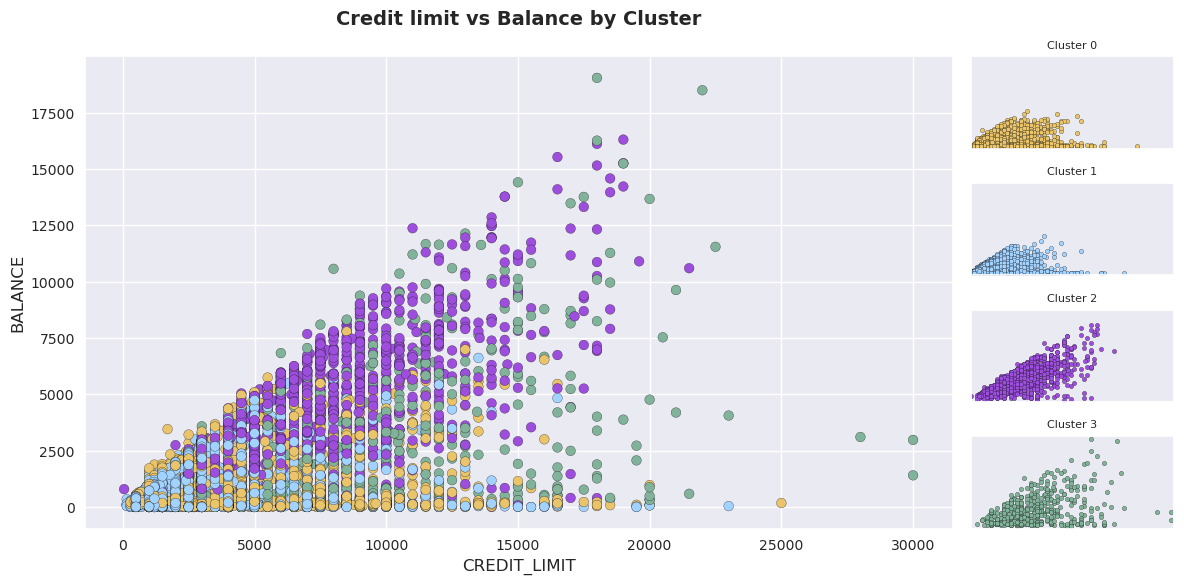

In [67]:
# Credit limit vs Balance
plot_profiling("CREDIT_LIMIT", "BALANCE")

People in clusters 2 and 3 have the highest credit limit and balance. So we can conclude that if the balance increases, the credit limit of a customer also increases. 

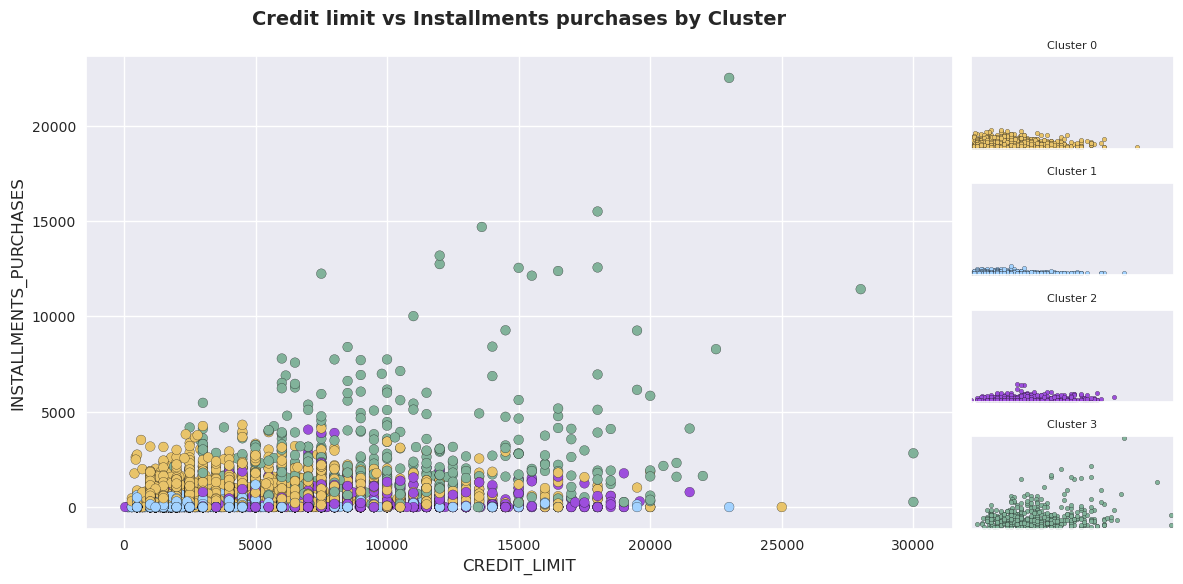

In [68]:
# Credit limit vs Installments purchases
plot_profiling("CREDIT_LIMIT", "INSTALLMENTS_PURCHASES")

As seen in the characteristics earlier, people in clusters 0 and 3 are more likely to make installments purchases. However, there's no correlation between the credit limit and installment purchases, that is, if a customer has a high credit limit, they do not necessarily make an installment purchase.

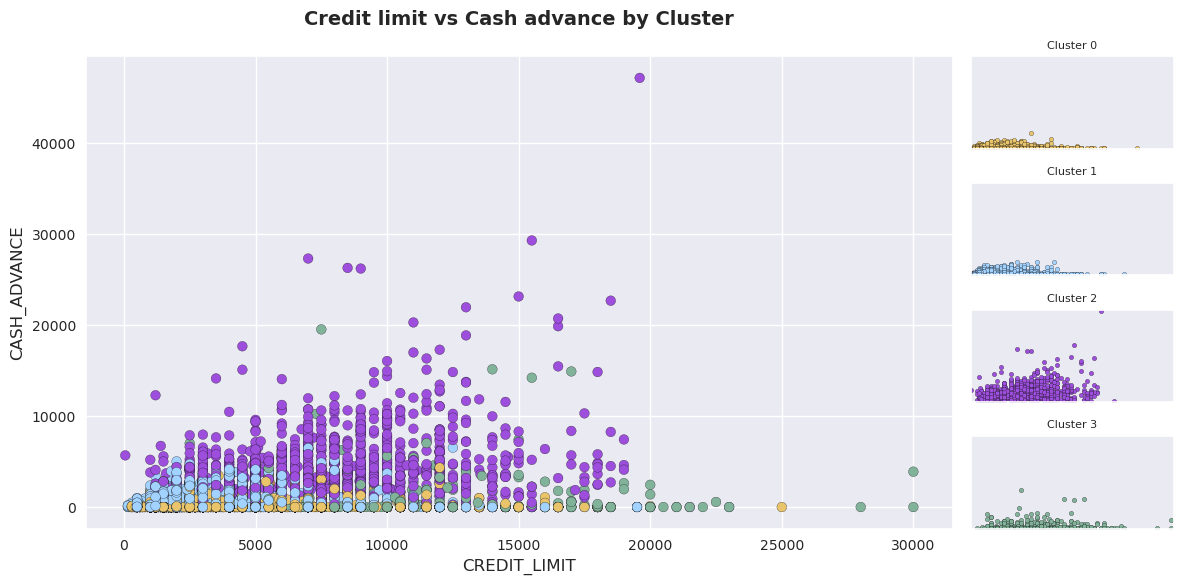

In [69]:
# Credit limit vs Cash advance
plot_profiling("CREDIT_LIMIT", "CASH_ADVANCE")

With this plot, we can see that people in cluster 2 are responsible for the majority of cash withdrawals. However, most people don't use this feature.

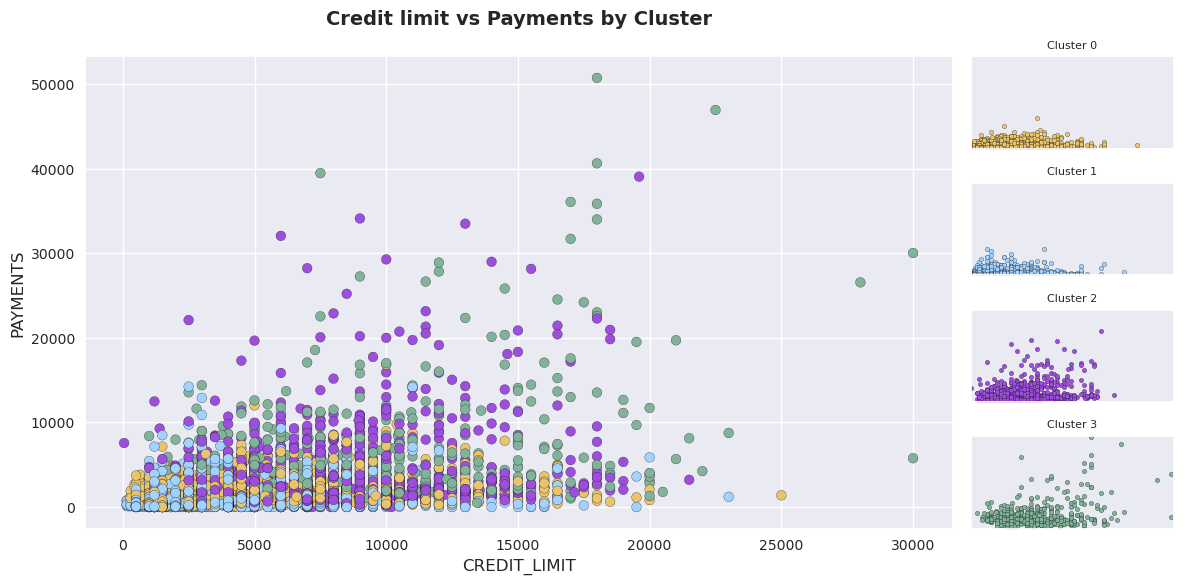

In [70]:
# Credit limit vs Payments
plot_profiling("CREDIT_LIMIT", "PAYMENTS")

There's a slight correlation between payments and credit limit. So people with more credit limit are more likely to make payments. But most people don't make payments at all.

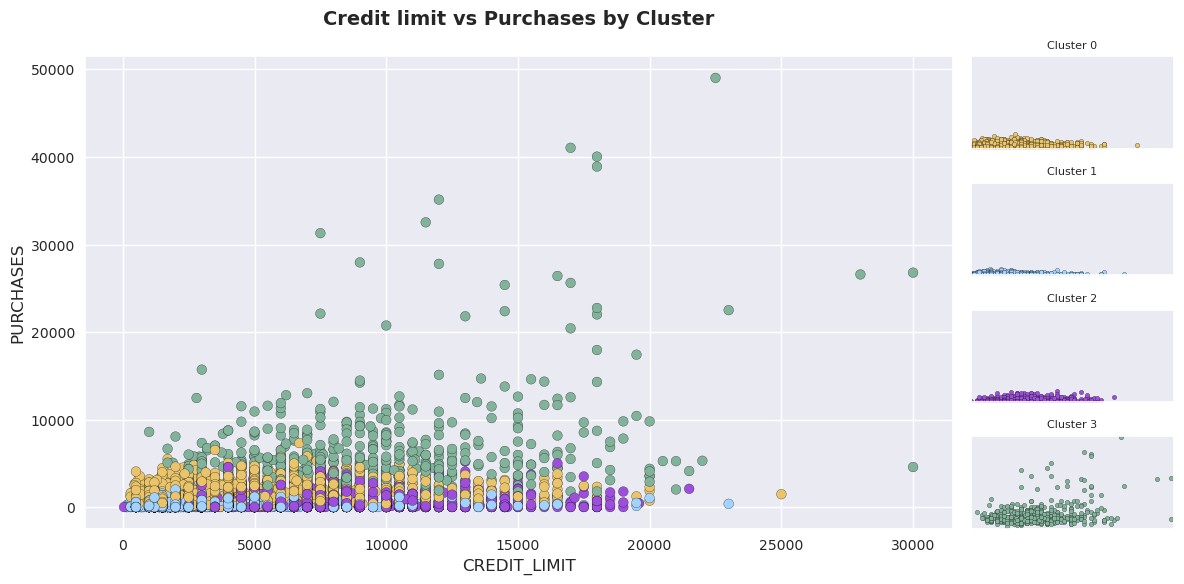

In [71]:
# Credit limit vs Purchases
plot_profiling("CREDIT_LIMIT", "PURCHASES")

Most people don't make purchases. But when they do it, they are likely to spend a low amount of money. Also, an increase in the credit limit doesn't affect this behavior.

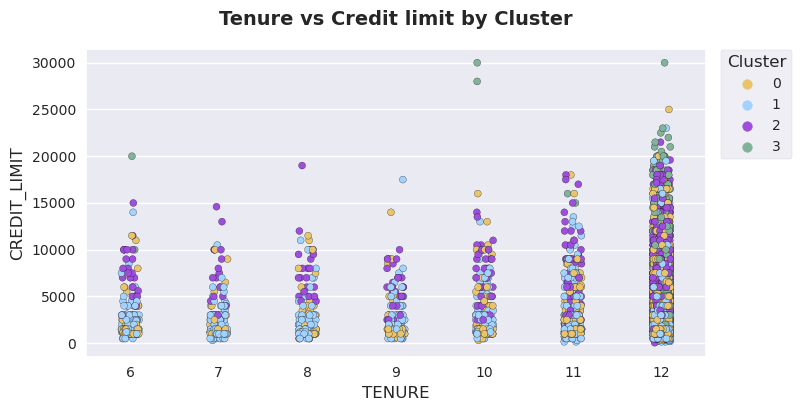

In [72]:
# Credit limit vs Tenure
cluster_colors = ["#e9c46a", "#a2d2ff", "#9d4edd", "#81b29a"]
labels = ["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3"]

sns.stripplot(data=df, x="TENURE", y="CREDIT_LIMIT", hue="CLUSTER", palette=cluster_colors, linewidth=0.2, edgecolor="k")
plt.title("Tenure vs Credit limit by Cluster", **title)
plt.legend(title="Cluster", ncols=1, bbox_to_anchor=(1.15, 1.02), frameon=True, fancybox=True)

plt.show()

As seen earlier, most people have a 12-month tenure. The credit limit doesn't seem to affect the tenure though.